In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:

# Helper function to calculate feature map size after convolution and pooling
def calculate_feature_map_size(input_size, kernel_size, stride, padding, pool_stride):
    # Apply convolution
    conv_output_size = (input_size - kernel_size + 2 * padding) // stride + 1
    # Apply max pooling
    pool_output_size = conv_output_size // pool_stride
    return pool_output_size


# # CNN1D Model Definition
# class CNN1D(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(CNN1D, self).__init__()

#         # Define the convolutional layers
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
#         self.bn1 = nn.BatchNorm1d(32)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm1d(64)
#         self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm1d(128)

#         # Pooling layer
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

#         # Dropout layer
#         self.dropout = nn.Dropout(0.3)

#         # Recalculate the size of the feature map after all convolutions and pooling layers
#         size_after_conv1 = calculate_feature_map_size(input_size, 5, 1, 2, 2)
#         size_after_conv2 = calculate_feature_map_size(size_after_conv1, 3, 1, 1, 2)
#         size_after_conv3 = calculate_feature_map_size(size_after_conv2, 3, 1, 1, 2)

#         # Adjust the input size based on actual convolution output
#         self.fc1 = nn.Linear(128 * size_after_conv3, 256)  # Adjusted to match the output size
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         # Apply convolutional layers with leaky relu and batch normalization
#         x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), 0.01))
#         x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), 0.01))
#         x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), 0.01))

#         # Flatten the output for the fully connected layers
#         x = x.view(x.size(0), -1)

#         # Apply fully connected layers with dropout and leaky relu
#         x = self.dropout(F.leaky_relu(self.fc1(x), 0.01))
#         x = self.dropout(F.leaky_relu(self.fc2(x), 0.01))
#         x = self.fc3(x)
#         return x



In [6]:
# Load the saved model
model_path = "/Users/book_kuno/Desktop/Outputs 23:04 rfc and 1dd cnn/2018/1dcnn/1dcnn_run1-0_5percent/cnn1d_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set input size and num_classes as per the saved model's architecture
input_size = 16  # MUST match what was used during training
num_classes = 8  # MUST match what was used during training

# Define your CNN1D model (make sure the definition matches the saved model)
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        reduced_size = input_size // 8  # after 3 pooling layers
        self.fc1 = nn.Linear(128 * reduced_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.bn1(self.conv1(x)), 0.01))
        x = self.pool(torch.nn.functional.leaky_relu(self.bn2(self.conv2(x)), 0.01))
        x = self.pool(torch.nn.functional.leaky_relu(self.bn3(self.conv3(x)), 0.01))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.leaky_relu(self.fc1(x), 0.01))
        x = self.dropout(torch.nn.functional.leaky_relu(self.fc2(x), 0.01))
        return self.fc3(x)

# Initialize and load the model
model = CNN1D(input_size=input_size, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Step 2: Load and sample the Dataset
data = pd.read_csv("/Users/book_kuno/Desktop/capture_final.csv")
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Preprocess the Data
data.columns = data.columns.str.strip()
data = data[data['label'].str.lower() != 'label']  # Remove 'Label' row if it exists
data = data.dropna()

encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])

# Ensure we only use the first 32 numeric features as in the original model
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('label')
numeric_columns = numeric_columns[:16]  # Match training input feature size

# Clean and scale
data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=numeric_columns)

scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

X = data[numeric_columns]
y = data['label']

# Step 4: Split the Dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Convert test data for prediction
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Step 6: Perform Prediction
with torch.no_grad():
    y_test_pred = model(X_test_tensor)

# Convert predictions to class labels
_, y_test_pred_labels = torch.max(y_test_pred, 1)
y_test_pred_labels = y_test_pred_labels.cpu().numpy()
y_test = y_test_tensor.cpu().numpy()

# Step 7: Evaluation
# Get unique labels in test set
unique_labels = sorted(np.unique(y_test))

# Get matching class names using encoder
target_names = encoder.inverse_transform(unique_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_labels, labels=unique_labels, target_names=target_names))



Classification Report:
                    precision    recall  f1-score   support

   attacker-benign       0.20      0.98      0.34      4766
attacker-goldeneye       0.44      0.01      0.01      7389
attacker-loic-http       0.00      0.00      0.00      8307
 attacker-slowhttp       0.00      0.00      0.00       918
attacker-slowloris       0.01      0.00      0.00      2792

         micro avg       0.20      0.20      0.20     24172
         macro avg       0.13      0.20      0.07     24172
      weighted avg       0.18      0.20      0.07     24172



/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Convert predictions and true labels back to readable attack names
all_predictions_str = encoder.inverse_transform(y_test_pred_labels)
all_true = encoder.inverse_transform(y_test)

# Classification report (only on labels actually present)
unique_labels = sorted(np.unique(y_test))
target_names = encoder.inverse_transform(unique_labels)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_test_pred_labels,
    labels=unique_labels,
    target_names=target_names
))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

# ROC Curve and AUC — only valid for binary classification
if len(unique_labels) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_labels, pos_label=unique_labels[1])
    roc_auc = auc(fpr, tpr)
    print("\nROC AUC:", roc_auc)
else:
    print("\nROC AUC: Skipped (not a binary classification problem)")


Accuracy: 0.1952


ValueError: y contains previously unseen labels: [5]

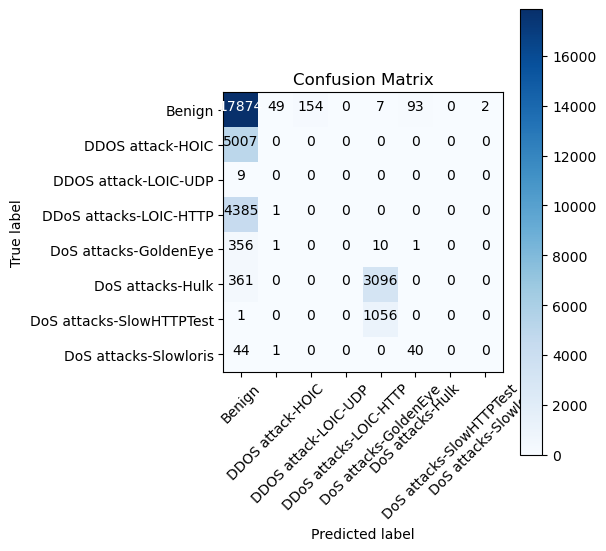

Output folder for this run: C:\Users\mrroo\Desktop\RP3\test\outputs/2019-large/1D-CNN/retest1-50per-2019large


In [ ]:
# --------------------------- ###
# Plotting the confusion matrix with axis labels
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    return fig

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_labels)
# Now plot confusion matrix with axis names
fig_conmatrix = plot_confusion_matrix(cm, encoder.classes_)
plt.show()

# Save results to files
import os

# Base output folder path
base_output_folder = r"C:\Users\mrroo\Desktop\RP3\test\outputs"

# Specify a unique run name (change this for each run)
model_name = "1D-CNN"  # Change as desired
year="2019-large"
run_name = "retest1-50per-2019large"  # Change as desired

# Combine the base folder with the run name to create a subfolder
output_folder = os.path.join(base_output_folder, year, model_name, run_name)

# Create the subfolder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

print("Output folder for this run:", output_folder)
# Create a results folder inside the output_folder if not exists
results_folder = os.path.join(output_folder, "evaluation_results")
os.makedirs(results_folder, exist_ok=True)



In [ ]:
# 1. Save overall accuracy and classification report to a text file.
results_text_path = os.path.join(results_folder, "evaluation_report.txt")
with open(results_text_path, "w") as f:
    f.write("Evaluation Metrics\n")
    f.write("==================\n\n")
    f.write("Overall Accuracy: {:.4f}\n\n".format(accuracy))
    f.write("Classification Report:\n")
    f.write(classification_report(all_true, all_predictions_str))
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(cm, separator=", "))
print("Evaluation report saved to:", results_text_path)

# 2. Save the confusion matrix to a CSV file.
cm_df = pd.DataFrame(cm, 
                     index=[encoder.classes_[i] for i in range(len(encoder.classes_))],
                     columns=[encoder.classes_[i] for i in range(len(encoder.classes_))])
cm_csv_path = os.path.join(results_folder, "confusion_matrix.csv")
cm_df.to_csv(cm_csv_path, index=True)
print("Confusion matrix saved to:", cm_csv_path)

# 3. Save the classification report as a CSV file.
# Parse the classification report into a dictionary, then into a DataFrame.
report_dict = classification_report(all_true, all_predictions_str, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_csv_path = os.path.join(results_folder, "classification_report.csv")
report_df.to_csv(report_csv_path, index=True)
print("Classification report saved to:", report_csv_path)

/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation report saved to: C:\Users\mrroo\Desktop\RP3\test\outputs/2019-large/1D-CNN/retest1-50per-2019large/evaluation_results/evaluation_report.txt
Confusion matrix saved to: C:\Users\mrroo\Desktop\RP3\test\outputs/2019-large/1D-CNN/retest1-50per-2019large/evaluation_results/confusion_matrix.csv


/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to: C:\Users\mrroo\Desktop\RP3\test\outputs/2019-large/1D-CNN/retest1-50per-2019large/evaluation_results/classification_report.csv


/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
